In [17]:
# My custom library of photoelastic tools
import sys
sys.path.append('/eno/jdfeathe/pepe/')

from pepe.preprocess import crossMask, checkImageType, rectMask, mergeMasks, circularMask
from pepe.simulate import genSyntheticResponse
from pepe.analysis import initialForceSolve, forceOptimize
from pepe.tracking import convCircle
from pepe.visualize import visCircles

import cv2

import numpy as np

import tensorflow as tf
import tensorflow.keras as keras

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140

In [2]:
dataFolder = '/eno/jdfeathe/DATA/SpaceJam/'
dataset = '2022-05-18_100_MHH_Gap5_1'
fileName = 'frame0352.bmp'

maskFolder = '/eno/jdfeathe/SpaceJam/masks/'

image = checkImageType(dataFolder + dataset + '/' + fileName)

maskArr = checkImageType(f'{maskFolder}{dataset.split("_")[0]}_FullMask.bmp')

circleTrackingKwargs = {"intensitySoftmax": 2., "intensitySoftmin": 1.8, "peakDownsample": 5,
                        "offscreenParticles": False, "radiusTolerance": None, "negativeHalo": True,
                        "fitPeaks": False, "allowOverlap": True, "kernelBlurKernel": 3}

radius = 160

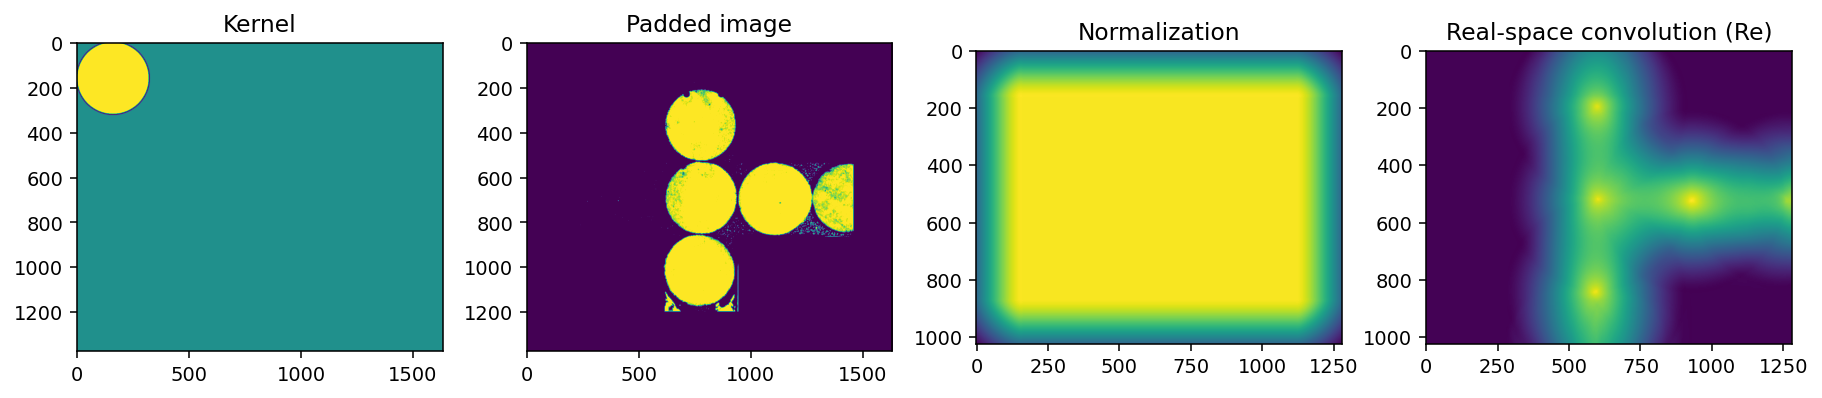

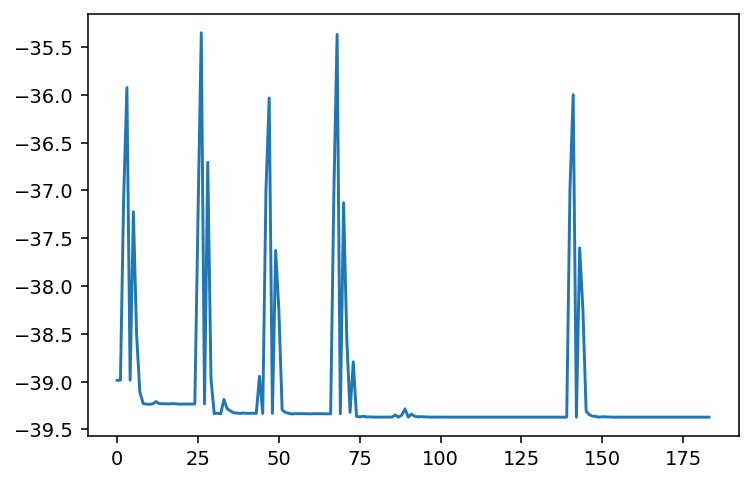

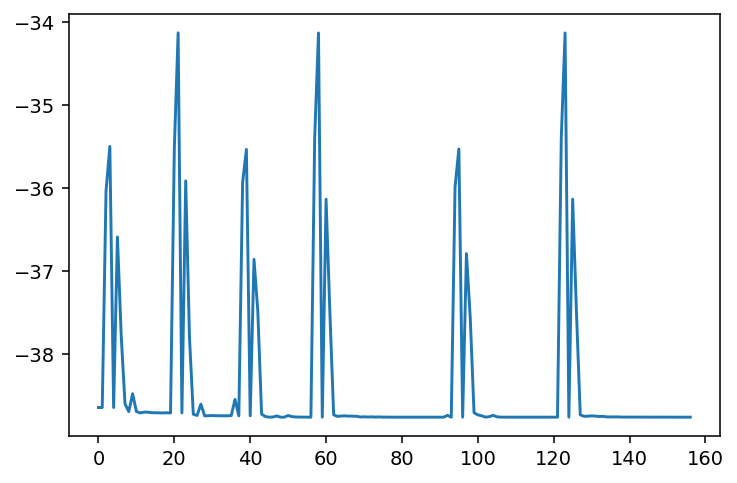

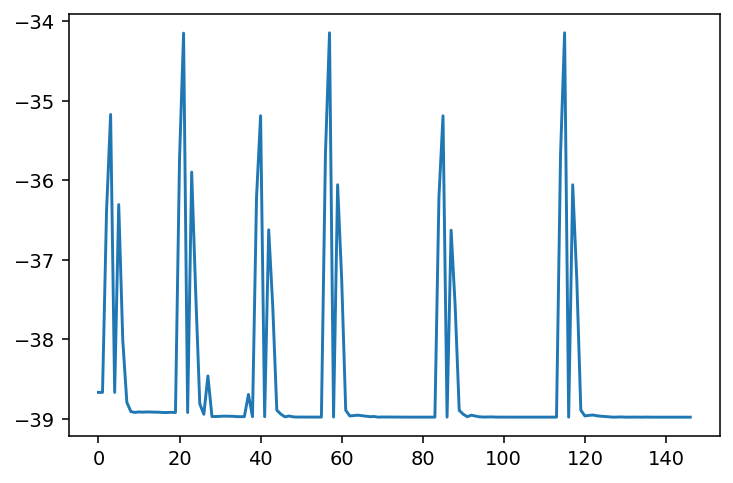

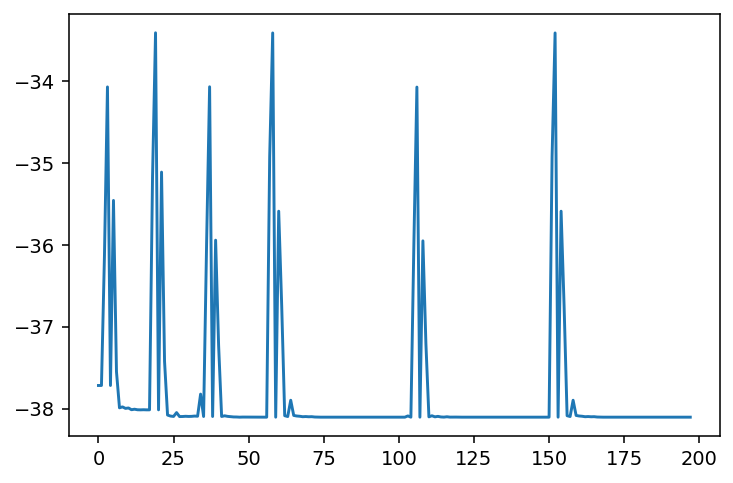

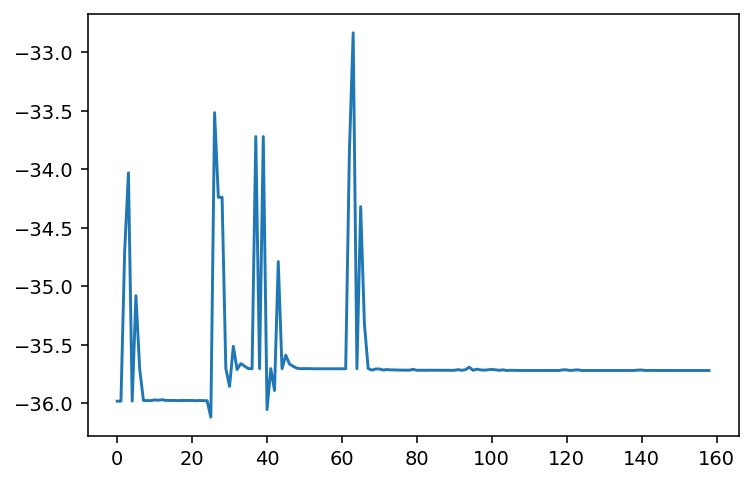

[[ 522.36287916  927.37346439]
 [ 841.18531377  591.48759732]
 [ 517.47042567  601.16138425]
 [ 193.0929346   598.36771456]
 [ 521.26744614 1259.55513988]]


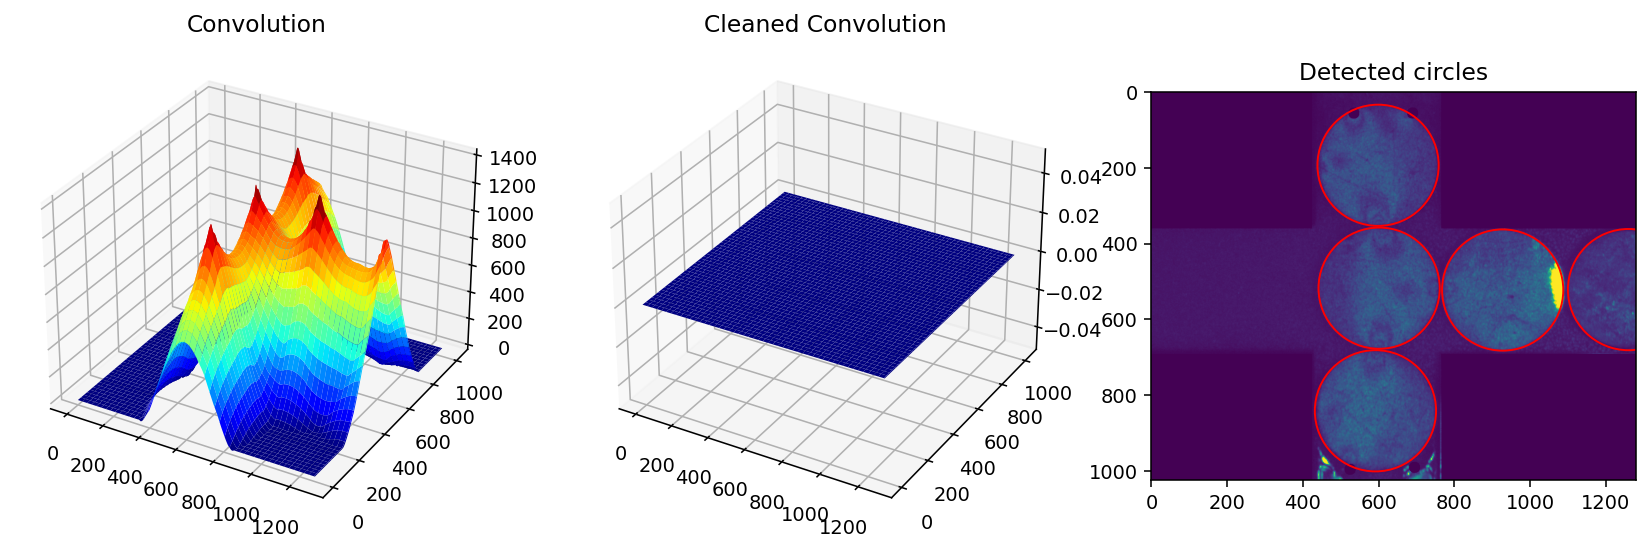

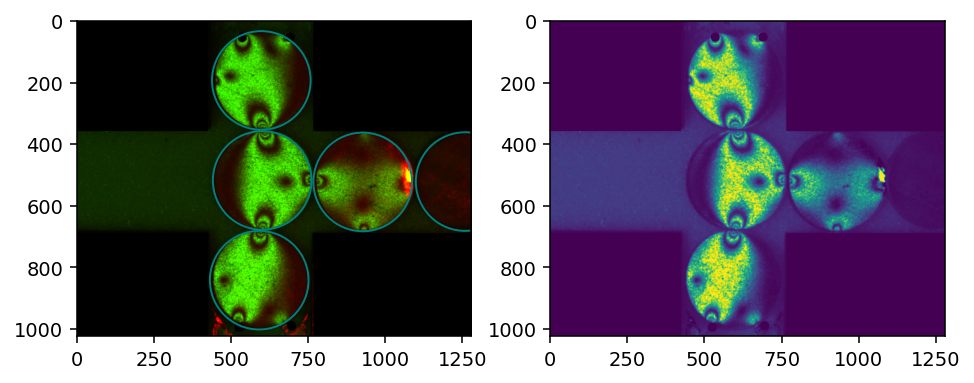

In [3]:
# g2 to force conversion is calibrated on the scale [0, 1], not [0, 255]
# We also blur the images a little, since they are visibly grainy
photoelasticChannel = cv2.blur(image[:,:,1].astype(np.float64) / 255, (3,3))


centers, radii = convCircle(image[:,:,0] * maskArr[:,:,0], radius, **circleTrackingKwargs, debug=True)

#centers = centers.astype(np.int64)
#radii = radii.astype(np.int64)

# A particle is about 1cm across
pxPerMeter = 2*np.mean(radii) / .015
# No idea what the actual value for this is
fSigma = 140

# Make some fake data with several potential wall contacts
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(maskArr * image)
for i in range(len(centers)):
    c = plt.Circle(centers[i][::-1], radii[i], label='Detected particles', color='teal', fill=False, linewidth=1)
    ax[0].add_artist(c)

print(centers)
    
ax[1].imshow(photoelasticChannel * maskArr[:,:,0])
plt.show()

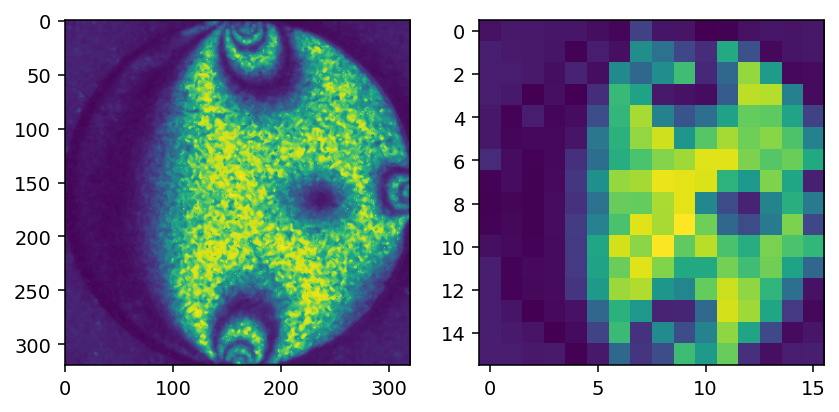

In [42]:
pIndex = 2
# Parameters of our force solving method
contactPadding = 30
g2MaskPadding = 3
contactMaskRadius = 30
brightfield = False

croppedImage = image[int(centers[pIndex][0]-radii[pIndex]):int(centers[pIndex][0]+radii[pIndex]),int(centers[pIndex][1]-radii[pIndex]):int(centers[pIndex][1]+radii[pIndex]),:]

yChannel = tf.image.rgb_to_yuv(croppedImage / 255.)[:,:,0]

dsImage = cv2.blur(np.array(yChannel), (3,3))[::20,::20]

fig, ax = plt.subplots(1, 2, figsize=(7,4))

ax[0].imshow(yChannel)
ax[1].imshow(dsImage)
plt.show()

In [43]:
model = keras.models.load_model('model')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 100)   57700     
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

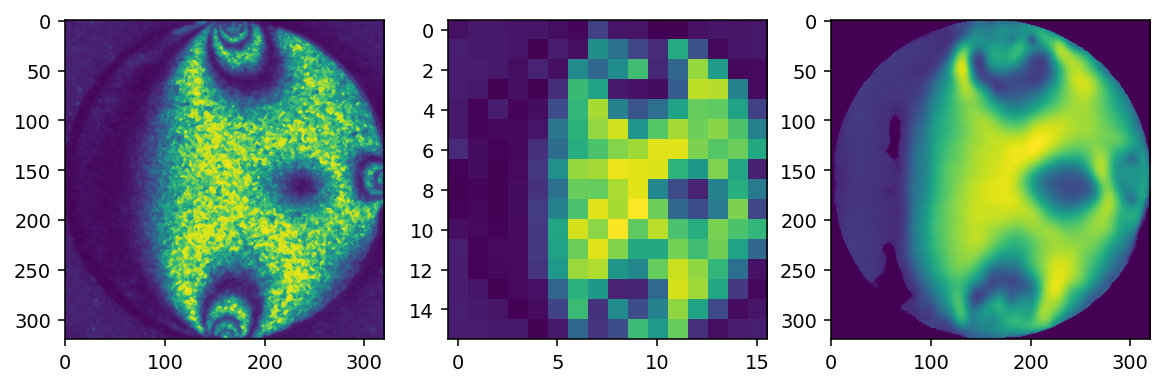

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(10,4))

upImage = np.array(model(dsImage[None,:,:])[0,:,:,0]) * circularMask(tuple(np.array(yChannel.shape)//2), np.array(yChannel.shape)/4., yChannel.shape[0]/4.)[:,:,0]
upImage = np.array(model(upImage[None,:,:])[0,::5,::5,0]) * circularMask(tuple(np.array(yChannel.shape)), np.array(yChannel.shape)/2., yChannel.shape[0]/2.)[:,:,0]

ax[0].imshow(yChannel)
ax[1].imshow(dsImage)
ax[2].imshow(upImage)
plt.show()

In [39]:

forceGuessArr, alphaGuessArr, betaGuessArr = initialForceSolve(cv2.blur(upImage, (7,7)),
                                                (np.array(upImage.shape))[None,:], np.array([upImage.shape[0] / 2.]), fSigma, pxPerMeter,
                                                contactPadding, g2MaskPadding,
                                                contactMaskRadius=contactMaskRadius,
                                                boundaryMask=maskArr, ignoreBoundary=False)

#forceGuessArr /= np.max([np.max(f) for f in forceGuessArr])

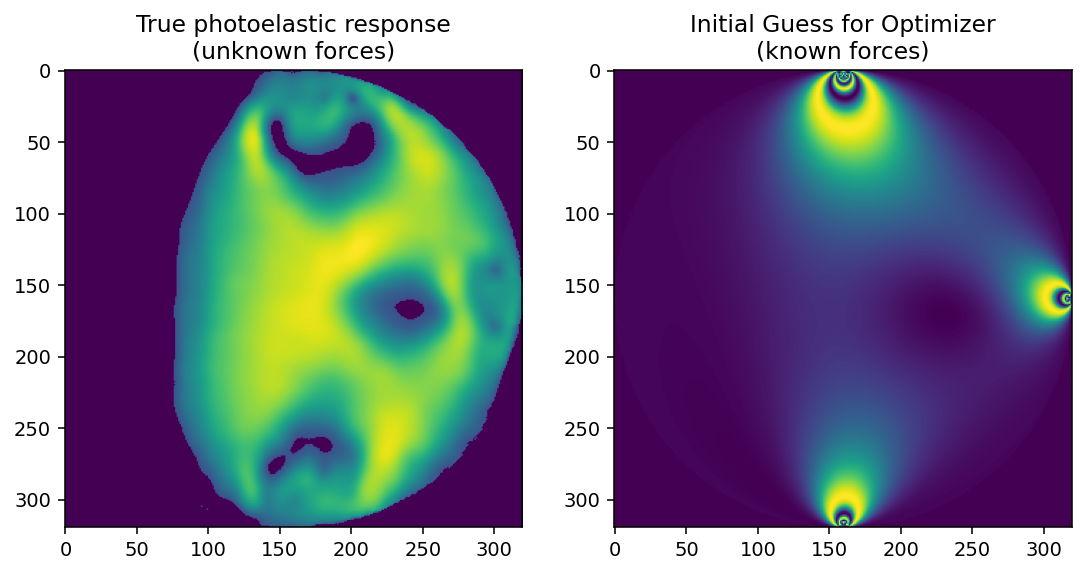

Absolute error (entire system): 11700.565081699966


In [76]:
forceGuessArr = [[.1, .2, .1]]
alphaGuessArr = [[0, 0, 0]]
betaGuessArr = [[0, np.pi, np.pi/2]]

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].imshow(upImage)
ax[0].set_title('True photoelastic response\n(unknown forces)')

estimatedPhotoelasticChannel = np.zeros_like(upImage, dtype=np.float64)

estimatedPhotoelasticChannel += genSyntheticResponse(np.array(forceGuessArr[0]),
                                                     np.array(alphaGuessArr[0]),
                                                     np.array(betaGuessArr[0]),
                                                     fSigma, radii[pIndex],
                                                     pxPerMeter, brightfield, imageSize=upImage.shape, center=np.array(upImage.shape)/2)

ax[1].imshow(estimatedPhotoelasticChannel)
ax[1].set_title('Initial Guess for Optimizer\n(known forces)')

fig.tight_layout()
plt.show()

print(f'Absolute error (entire system): {np.sum(upImage - estimatedPhotoelasticChannel)}')

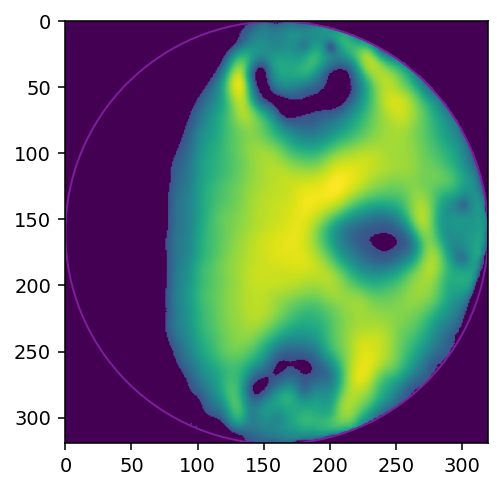

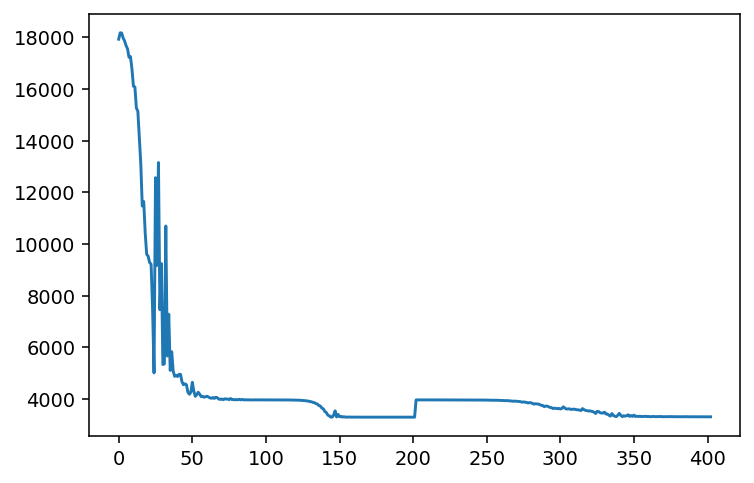

In [77]:
# Now optimize each particle's forces
optimizedForceArr = []
optimizedBetaArr = []
optimizedAlphaArr = []
resArr = []

#reconstructImage = cv2.blur(np.array(image[:,:,1]) / 255., (3,3))
reconstructImage = upImage
reconstructImage[reconstructImage < .25*np.max(reconstructImage)] = 0
reconstructImage = (reconstructImage - np.min(reconstructImage)) / np.max(reconstructImage)
#reconstructImage = cv2.blur(np.array(reconstructImage), (3,3))
#reconstructImage = dsImage

center = np.array(reconstructImage.shape)/2
#radius = reconstructImage.shape[0]/2
radius = radii[pIndex]
#center = centers[pIndex]

plt.imshow(reconstructImage)
visCircles([center], [radii[pIndex]], ax=plt.gca())
plt.show()

optimizationKwargs = {"maxEvals": [100, 100, 200], "method": 'nelder',
                      "parametersToFit": [['f'], ['a'], ['f', 'a']],
                      "allowRemoveForces": True, "useTolerance": True,
                      "allowAddForces": True, "minForceThreshold": .01,
                      "localizeAlphaOptimization": False, "imageScaleFactor": 1,
                      "forceBalanceWeighting": .02}

optForceArr, optBetaArr, optAlphaArr, res = forceOptimize(forceGuessArr[0], betaGuessArr[0], alphaGuessArr[0],
                                                          radius, center, reconstructImage, fSigma, pxPerMeter, brightfield,
                                                          **optimizationKwargs, debug=True)
optimizedForceArr.append(optForceArr)
optimizedBetaArr.append(optBetaArr)
optimizedAlphaArr.append(optAlphaArr)
resArr.append(res)

for res in resArr:
    plt.plot(res)

plt.show()

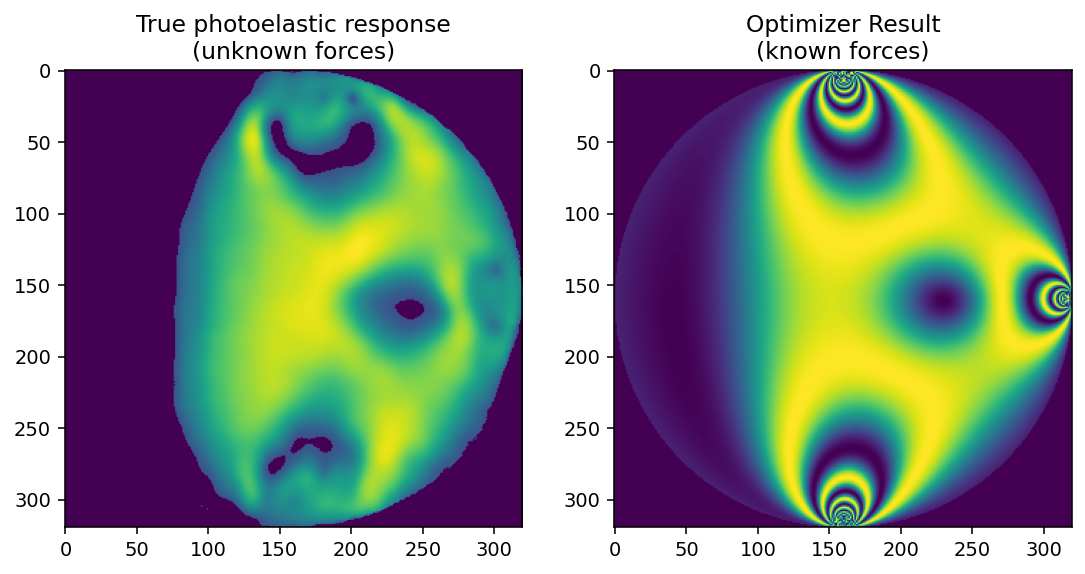

Absolute error (entire system): -16525.28920617931


In [78]:
forceGuessArr = [[.2, .2, .1]]
alphaGuessArr = [[-.1, .1, 0]]
betaGuessArr = [[0, np.pi, np.pi/2]]

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].imshow(reconstructImage)
ax[0].set_title('True photoelastic response\n(unknown forces)')

estimatedPhotoelasticChannel = np.zeros_like(upImage, dtype=np.float64)

estimatedPhotoelasticChannel += genSyntheticResponse(np.array(optimizedForceArr[0]),
                                                     np.array(optimizedAlphaArr[0]),
                                                     np.array(optimizedBetaArr[0]),
                                                     fSigma, radii[pIndex],
                                                     pxPerMeter, brightfield, imageSize=upImage.shape, center=np.array(upImage.shape)/2)

ax[1].imshow(estimatedPhotoelasticChannel)
ax[1].set_title('Optimizer Result\n(known forces)')

fig.tight_layout()
plt.show()

print(f'Absolute error (entire system): {np.sum(upImage - estimatedPhotoelasticChannel)}')

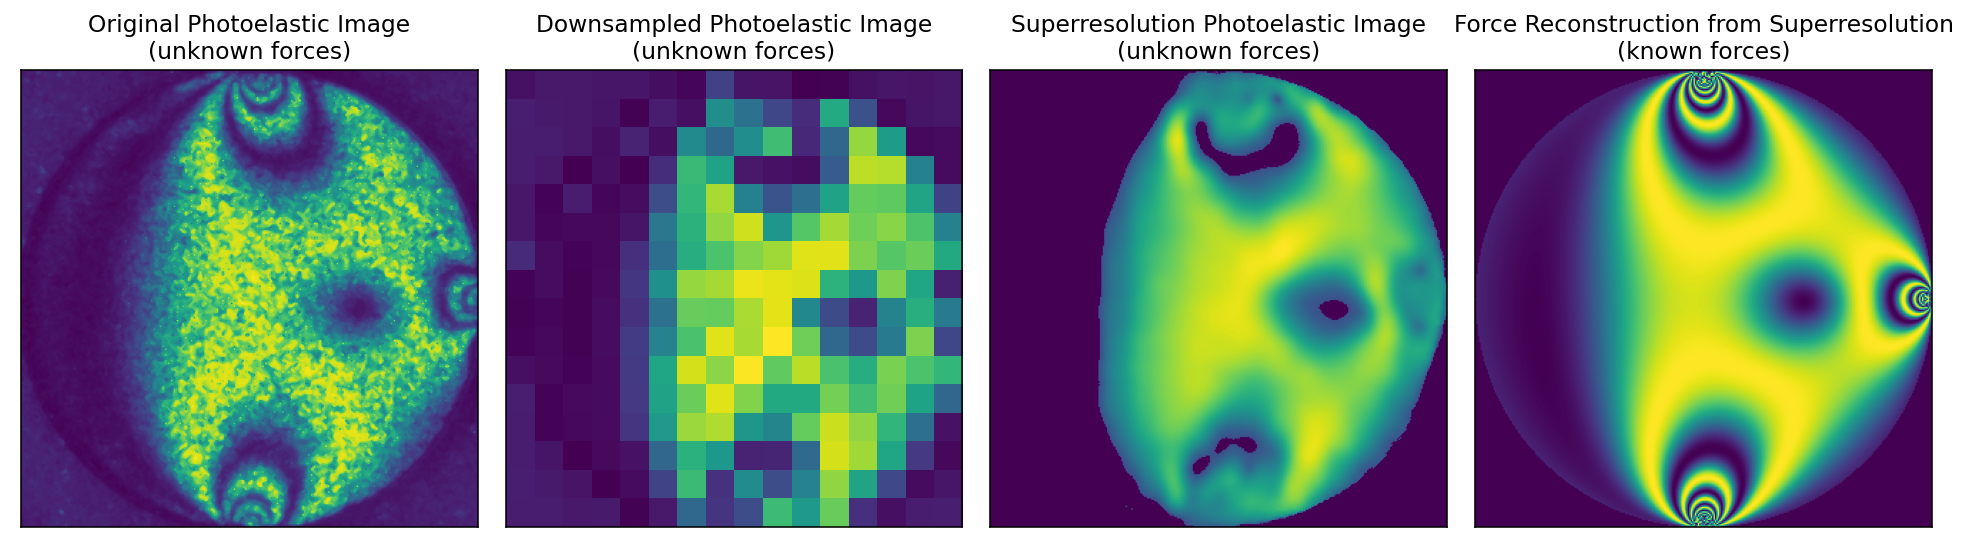

In [79]:
fig, ax = plt.subplots(1, 4, figsize=(14,4))

ax[0].imshow(yChannel)
ax[0].set_title('Original Photoelastic Image\n(unknown forces)')

ax[1].imshow(dsImage)
ax[1].set_title('Downsampled Photoelastic Image\n(unknown forces)')

ax[2].imshow(upImage)
ax[2].set_title('Superresolution Photoelastic Image\n(unknown forces)')

ax[3].imshow(estimatedPhotoelasticChannel)
ax[3].set_title('Force Reconstruction from Superresolution\n(known forces)')

for i in range(4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.tight_layout()
plt.show()

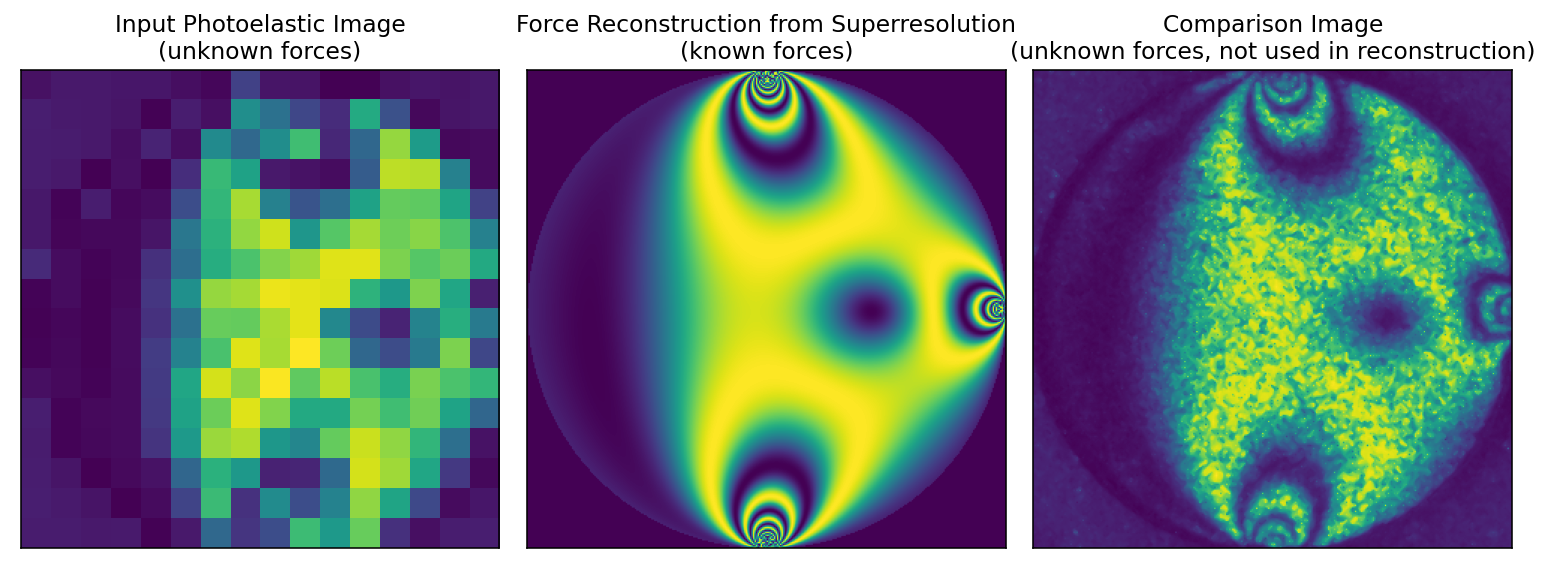

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(11,4))

ax[0].imshow(dsImage)
ax[0].set_title('Input Photoelastic Image\n(unknown forces)')

ax[1].imshow(estimatedPhotoelasticChannel)
ax[1].set_title('Force Reconstruction from Superresolution\n(known forces)')

ax[2].imshow(yChannel)
ax[2].set_title('Comparison Image\n(unknown forces, not used in reconstruction)')

for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.tight_layout()
plt.savefig('prelim_real_test.png')
plt.show()